In [1]:
import os, sys; sys.path.append(os.path.dirname(os.getcwd()))
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import multimodal_vae
import torch_mvae_util as U
import util.RAVDESS_dataset_util as Rd
from train_mvae import build_model, train

In [2]:
from functools import partial
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune import JupyterNotebookReporter

In [3]:
num_workers=32

max_num_epochs=100
num_epochs=100
num_samples=100
betas=[0.95, 0.98]
data_dir = '/home/studenti/ballerini/Multimodal_RSA/src/util/au-emo_2.csv'
checkpoint_dir='./tuning'
expert = 'poe'

modes={'au':True, 'face':None, 'emotion':True}

config = {
    'batch_size':tune.choice([64, 128, 256, 512]),
    'z_dim':tune.choice([25, 50]),
    'hidden_dim':tune.choice([128, 256, 512]),
    'lr': tune.choice([1e-2, 1e-3, 1e-4, 1e-5]),
    'alpha': tune.choice([1, 5e-1]),
    'beta': tune.choice([1e-3, 1e-4, 1e-5, 1e-6, 1e-7]),
    'au_weight':tune.loguniform(1e-3, 1e6),
    'emotion_weight':tune.loguniform(1e-3, 1e6),
}

In [4]:
def load_data(data_dir='./data'):
    au_dataset = pd.read_csv(data_dir).to_numpy()
    au = au_dataset[:,:-2]
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    au = scaler.fit_transform(au)
    
    emotions = au_dataset[:,-2].astype(int)-1
    au_dataset = [(x, y) for x, y in zip(au, emotions)]

    trainingset_len = int(len(au_dataset) * 0.8)
    testset_len = len(au_dataset) - trainingset_len

    trainset, testset = torch.utils.data.random_split(
        au_dataset, 
        [trainingset_len, testset_len],
        generator=torch.Generator().manual_seed(66)
    )
    
    return trainset, testset

In [5]:
def hyper_train(config, data_dir, num_epochs, use_cuda=True, checkpoint_dir=None):
    model: torch.nn.Module = build_model(
        cat_dim=8,      
        au_dim=17,     
        latent_space_dim=config['z_dim'],     
        hidden_dim=config['hidden_dim'],               
        num_filters=None,                 
        modes=modes,              
        au_weight=config['au_weight'],           
        emotion_weight=config['emotion_weight'],              
        expert_type=expert,                  
        use_cuda=True).double()
        
    optimizer = torch.optim.Adam(
        params=model.parameters(), 
        lr=config['lr'], 
        betas=betas)
    '''    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    '''
    trainset, testset = load_data(data_dir)
    
    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])
    
    trainloader = DataLoader(
        trainset, 
        batch_size=config['batch_size'],
        shuffle=True, 
        num_workers=32)

    valloader = DataLoader(
        val_subset, 
        batch_size=config['batch_size'],
        shuffle=True, 
        num_workers=32)
    
    beta = config['beta']
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            au, emotions = data
            
            if use_cuda:
                if au is not None:
                    au = au.cuda()
                if emotions is not None:
                    emotions = emotions.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()
            
            #-------------------------------------------------
            (
                au_reconstruction,
                emotion_reconstruction,
                z_loc_expert,
                z_scale_expert,
                latent_sample
            ) = model(
                au=au,
                emotions=emotions
            )

            loss = model.loss_function(
                au=au,
                emotions=emotions,
                au_reconstruction=au_reconstruction,
                emotions_reconstruction=emotion_reconstruction,
                z_loc=z_loc_expert,
                z_scale=z_scale_expert,
                beta=beta,
                latent_sample=latent_sample
            )
            
            loss["total_loss"].backward()
            optimizer.step()
            #-------------------------------------------------
            (
                au_reconstruction,
                emotion_reconstruction,
                z_loc_expert,
                z_scale_expert,
                latent_sample
            ) = model(
                au=au,
                emotions=None
            )

            loss = model.loss_function(
                au=au,
                emotions=None,
                au_reconstruction=au_reconstruction,
                emotions_reconstruction=emotion_reconstruction,
                z_loc=z_loc_expert,
                z_scale=z_scale_expert,
                beta=beta,
                latent_sample=latent_sample
            )
            
            loss["total_loss"].backward()
            optimizer.step()
            #-------------------------------------------------
            (
                au_reconstruction,
                emotion_reconstruction,
                z_loc_expert,
                z_scale_expert,
                latent_sample
            ) = model(
                au=None,
                emotions=emotions
            )

            loss = model.loss_function(
                au=None,
                emotions=emotions,
                au_reconstruction=au_reconstruction,
                emotions_reconstruction=emotion_reconstruction,
                z_loc=z_loc_expert,
                z_scale=z_scale_expert,
                beta=beta,
                latent_sample=latent_sample
            )
            
            loss["total_loss"].backward()
            optimizer.step()
            #-------------------------------------------------
            
        y_true = []
        y_pred = []
        val_loss = 0
        val_steps = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                au, emotions = data
            
                if use_cuda:
                    if au is not None:
                        au = au.cuda()
                    if emotions is not None:
                        emotions = emotions.cuda()

                (
                    au_reconstruction,
                    emotion_reconstruction,
                    z_loc_expert,
                    z_scale_expert,
                    latent_sample
                ) = model(
                    au=au,
                    emotions=None
                )
                
                loss = model.loss_function(
                    au=au,
                    emotions=emotions,
                    au_reconstruction=au_reconstruction,
                    emotions_reconstruction=emotion_reconstruction,
                    z_loc=z_loc_expert,
                    z_scale=z_scale_expert,
                    beta=beta,
                    latent_sample=latent_sample
                )
                
                reconstructed_emotions = torch.argmax(emotion_reconstruction, 1)
                y_true += emotions.cpu()
                y_pred += reconstructed_emotions.cpu()
                val_loss += loss['total_loss'].cpu().numpy()
                val_steps += 1
                
        matrix = confusion_matrix(y_true, y_pred)
        accuracy = matrix.diagonal()/matrix.sum(axis=1)
        accuracy = sum(accuracy) / len(accuracy)
        
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((model.state_dict(), optimizer.state_dict()), path)
        

        tune.report(loss=(val_loss / val_steps), accuracy=accuracy)
    print("Finished Training")
    

In [6]:
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=max_num_epochs,
    grace_period=10,
    reduction_factor=3)    

reporter = JupyterNotebookReporter(
    True,
    metric_columns=["accuracy","loss","training_iteration"])

result = tune.run(
        partial(hyper_train, data_dir=data_dir, num_epochs=num_epochs, checkpoint_dir=checkpoint_dir),
        resources_per_trial={"cpu": 8, "gpu": 0.1},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter)

best_trial = result.get_best_trial("accuracy", "max", "last")

print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(best_trial.last_result["accuracy"]))

Trial name,status,loc,alpha,au_weight,batch_size,beta,emotion_weight,hidden_dim,lr,z_dim,accuracy,loss,training_iteration
hyper_train_15719_00000,TERMINATED,159.149.133.23:748389,0.5,0.0976166,256,1e-06,0.0137705,512,0.01,25,0.130536,0.894848,100
hyper_train_15719_00001,TERMINATED,159.149.133.23:748419,0.5,310504,256,0.001,62.8919,512,0.01,50,0.143479,2957.23,10
hyper_train_15719_00002,TERMINATED,159.149.133.23:748422,0.5,59991.3,128,1e-07,20.6122,512,1e-05,50,0.366647,564.042,10
hyper_train_15719_00003,TERMINATED,159.149.133.23:748424,0.5,0.00282092,128,0.0001,0.00166803,256,0.001,50,0.12086,0.0181069,100
hyper_train_15719_00004,TERMINATED,159.149.133.23:748426,1,3718.85,64,1e-05,2155.27,512,1e-05,25,0.343998,3983.32,10
hyper_train_15719_00005,TERMINATED,159.149.133.23:748428,0.5,154.374,64,1e-07,252931,256,0.01,50,0.151571,1.18988e+07,10
hyper_train_15719_00006,TERMINATED,159.149.133.23:905286,1,0.0570935,64,1e-06,521.791,256,0.0001,50,0.302611,1690.35,10
hyper_train_15719_00007,TERMINATED,159.149.133.23:936534,0.5,13669.1,128,1e-06,3341.23,512,0.001,50,0.163214,31920,10
hyper_train_15719_00008,TERMINATED,159.149.133.23:1014683,1,442567,256,0.001,53543.8,128,1e-05,50,0.377753,108029,10
hyper_train_15719_00009,TERMINATED,159.149.133.23:1024429,1,10.0494,256,0.0001,0.105006,128,0.0001,50,0.20922,0.452245,30


2022-07-08 23:09:30,629	INFO tune.py:747 -- Total run time: 3510.98 seconds (3510.73 seconds for the tuning loop).


Best trial config: {'batch_size': 64, 'z_dim': 25, 'hidden_dim': 512, 'lr': 0.0001, 'alpha': 0.5, 'beta': 1e-07, 'au_weight': 797.4885054561686, 'emotion_weight': 0.0038429846591218927}
Best trial final validation loss: 0.29597450689542415
Best trial final validation accuracy: 0.7138796143095123


In [7]:
best_trial.config

{'batch_size': 64,
 'z_dim': 25,
 'hidden_dim': 512,
 'lr': 0.0001,
 'alpha': 0.5,
 'beta': 1e-07,
 'au_weight': 797.4885054561686,
 'emotion_weight': 0.0038429846591218927}

In [8]:
model_args = {
    'cat_dim':8,      
    'au_dim':17,     
    'latent_space_dim':best_trial.config['z_dim'],     
    'hidden_dim':best_trial.config['hidden_dim'],               
    'num_filters':None,                 
    'modes':modes,
    
    'au_weight':best_trial.config['au_weight'],           
    'emotion_weight':best_trial.config['emotion_weight'],              
    'expert_type':expert,                  
    'use_cuda':True}

print(model_args)
train_args = {
    'learning_rate' : best_trial.config['lr'],
    'alpha':best_trial.config['alpha'],
    'beta': best_trial.config['beta'],
    'optim_betas' : betas,
    'num_epochs' : num_epochs,
    'batch_size' : best_trial.config['batch_size']
}
print(train_args)

{'cat_dim': 8, 'au_dim': 17, 'latent_space_dim': 25, 'hidden_dim': 512, 'num_filters': None, 'modes': {'au': True, 'face': None, 'emotion': True}, 'au_weight': 797.4885054561686, 'emotion_weight': 0.0038429846591218927, 'expert_type': 'poe', 'use_cuda': True}
{'learning_rate': 0.0001, 'alpha': 0.5, 'beta': 1e-07, 'optim_betas': [0.95, 0.98], 'num_epochs': 100, 'batch_size': 64}


In [9]:
best_trained_model =  build_model(**model_args).double()

In [10]:
best_checkpoint_dir = best_trial.checkpoint.value
model_state, optimizer_state = torch.load(os.path.join(
        best_checkpoint_dir, "checkpoint"))

best_trained_model.load_state_dict(model_state)

<All keys matched successfully>

In [11]:
save_model = True

if save_model:
    PATH = "../trained_models/best_train_"+expert+".save"
    torch.save({'model_args' : model_args,
                'train_args' : train_args,
                'model_state' : model_state
                }, PATH)

100%|████████████████████████████████████████████████████████████████| 2048/2048 [00:05<00:00, 375.01it/s]


              precision    recall  f1-score   support

     neutral       0.48      0.16      0.24      4257
        calm       0.42      0.58      0.48      4211
       happy       0.54      0.26      0.35      4030
         sad       0.60      0.94      0.73      4119
       angry       0.45      0.30      0.36      4099
     fearful       0.18      0.35      0.24      3958
     disgust       0.14      0.04      0.06      4008
   surprised       0.11      0.14      0.12      4086

    accuracy                           0.35     32768
   macro avg       0.36      0.35      0.32     32768
weighted avg       0.37      0.35      0.33     32768



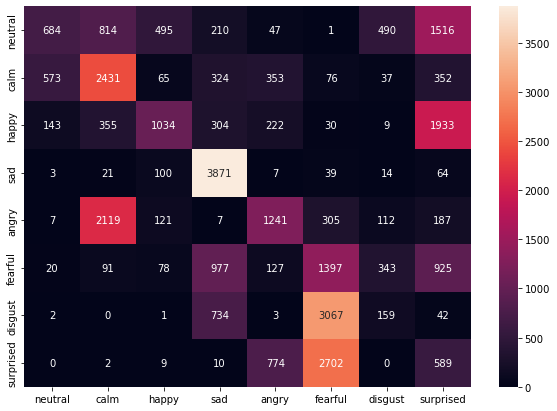

In [12]:
labels = list(Rd.emocat.values())
y_true, y_pred = U.au_recon_and_classiffication_accuracy(best_trained_model, num_samples=2048)
cr = classification_report(y_true, y_pred, target_names=labels)
cm = confusion_matrix(y_true, y_pred)
cm = pd.DataFrame(cm, index = [i for i in labels],columns = [i for i in labels])

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt="d")
print(cr)